# This is the template for coursework B - Add a suitable title

<div class="alert alert-block alert-danger">
<b>Candidate number: Your candidate number here (this is a five digit number). </b>

- This Coursework contributes <b>80%</b> to your overall unit mark.

- Will be marked anonymously.

- Keep to word limits (+- a few words).

- You can use the WordCounter notebook to check your word count.

- Code & figure captions do not count towards word limits.
</div>

### Abstract: 

Here, give an overview of your work, make sure to describe the science background, methods, results as well as comparisons to literature data. Keep this short.
<div class="alert alert-block alert-danger">
    
<b>word limit 250 words.</b>

#### Imports: give all your imports in a box here. Any custom code you have stored in a .py file needs to be submitted with your coursework. You can freely use all code provided to you as part of this course. If you use code not encountered in the course, give a link to the online repo.

In [57]:
#Data handling
import numpy as np
import pandas as pd 
from astropy.io import fits #used to open fits files in which data are stored
import glob

#Signal processing imports
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

#Modelling imports 
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import pymc3_ext as pmx

#Visualization imports 
import arviz as az
import corner
import matplotlib.pyplot as plt

#Progress bars
import tqdm
from typing import Optional

#Utils file 
from utils import fold_lightcurve, model_curve


<div class="alert alert-block alert-danger">
<b>Make sure to include the relevant python files in your upload</b>

### 1. Introduction:

Give an introduction to your coursework. This should be a short description of exoplanets as well as a description of background relevant to your Discussion.

Your introduction should be understandable to a student having taken Intro to astro and Planets & Exoplanets. 

<div class="alert alert-block alert-danger">
<b>Word limit: 600 words</b>

A central problem in astronomy is the search for other planets bearing life.
In recent years TESS George R. Ricker(2018) surveys have discovered thousands of confirmed exoplanets orbiting a range of stellar hosts. Of these confirmed transits indicating an exoplanet orbiting a star, only a small subset of these bodies are candidates for hosting life. There has consequently been a large body of research (CITE ME) on generating likely candidates for habitable exoplanets from large-scale sky surveys such as TESS or KEPLER- Michael Mewhinney (2013).



Keystone indicators for habitability come from a range of sources; from time series data of the stellar flux of a star, we can detect exoplanets by periodic drops in flux. These troughs, coined 'transits' by astronomers, are caused by the partial occlusion of the view of a star from an observation telescope.
After confirming the presence of an exoplanet, astronomical spectrometry and radial velocity can be used to find the exoplanet's mass, atmospheric composition, and temperature as the key indicators of suitability for life.
Before justifying this extra analysis and instrument time however, we can look at the transit curves to derive the mass ratio of the host star and exoplanet and the orbit's semi-major axis.


Additionally, measuring stellar and transit parameters allows researchers to further describe the exoplanet's path through space, and by extension confidence in their astrophysical model. Parameters of interest are the stellar limb darkening (the extent to which the central part of the star 'disk' seems brighter than its edges), the impact parameter (the verticle elevation distance between the center of the star and the exoplanet as defined below)

$$ b = \frac{a cos(i)}{R_{*}}$$


Often the extent to which a given exoplanet's orbit deviates from being circular, its eccentricity, is also considered a prominent factor in habitability, Yuwei Wang(2017).

Striving to be confident in their results for exoplanet measurements, instead of expressing these quantities as scalars, many astronomers choose to treat transit light curve data as a stochastically variable time series. Researchers can obtain probabilistic estimates of the parameters characterizing these transits using gaussian process or Markov-chain Monte Carlo (MCMC) simulations. These models yield bayesian estimates for their parameters, allowing for rigorous considerations of error, confidence, and parameter correlation.


In this work, we will perform an in-depth analysis of a reading of stellar flux from the Kepler telescope to confirm the existence of two orbiting exoplanets. Using various periodograms, we will derive estimates of the number of exoplanets in the stellar system and their respective orbital periods. After this, we will find their mass ratio and average transit length, taking an average over a series of transits.


Additionally, for the body with the larger semi-major axis more rigorous analysis will be applied- we will fit a gaussian process model to its folded light curve. From this model, we will generate estimates of the posterior distribution for stellar properties, orbital parameters, and transit jitter. This will allow us to describe the environment of the exoplanet, and by extension, its suitability for hosting life. Following this, we will perform statistical analysis on the goodness of fit of the transit light curve for all found exoplanets, and any correlations in model parameters that may affect our predictions.

### 2. Results - Modelling of Kepler lightcurve

$\bullet$ describe fitting of transit depths and present results with errors

$\bullet$ describe periodogram and identification of periodic features in lightcurves

$\bullet$ describe motivation for any additional fitting you have done

$\bullet$ include code for all modelling in attached code or inline, describe limitations and assumptions made

<div class="alert alert-block alert-danger">
    
<b>Keep this concise: word limit 750 words</b>

In [5]:
mykepler = '1'

In [7]:
#Get arrays for the flux so that we can do further analysis 

total_flux, total_time, total_flux_error = [], [], []

for lcfile in tqdm.tqdm(glob.glob('Data/Object%slc/kplr*.fits' %(mykepler))):
    tmp = fits.open(lcfile)
    tmptime = (tmp[1].data['TIME'])
    tmpflux = (tmp[1].data['PDCSAP_FLUX'])
    tmperror = (tmp[1].data['PDCSAP_FLUX_ERR'])

    #Remove Nans for flux and flux error 
    tmpflux_mask, tmperror_mask  = np.isfinite(tmpflux), np.isfinite(tmperror)
    total_mask = np.logical_and(tmpflux_mask, tmperror_mask)
    time_sample, flux_sample, flux_sample_error = tmptime[total_mask], tmpflux[total_mask], tmpflux[total_mask]

    #Normalize the flux to be centred around one
    normalized_flux, normalized_flux_error = (flux_sample / np.mean(flux_sample)), (flux_sample_error / np.mean(flux_sample))

    #Run a savgol filter to do outlier removal 
    from scipy.signal import savgol_filter
    interp_savgol = savgol_filter(normalized_flux, window_length=271, polyorder=3)

    total_flux.append(normalized_flux/ interp_savgol)
    total_flux_error.append(normalized_flux_error / interp_savgol)
    total_time.append(time_sample)

    tmp.close()

100%|██████████| 17/17 [00:00<00:00, 120.16it/s]


In [8]:
#Quick correction to get one array for flux, flux_err and time sorted in order. 
flux_arr = np.concatenate(total_flux)
flux_error_arr = np.concatenate(total_flux_error)
time_arr = np.concatenate(total_time)

sorted_flux = np.array([x for _, x in sorted(zip(time_arr, flux_arr), key=lambda pair: pair[0])])
sorted_time = np.array([_ for _, x in sorted(zip(time_arr, flux_arr), key=lambda pair: pair[0])])
sorted_flux_err = np.array([x for _, x in sorted(zip(time_arr, flux_error_arr), key=lambda pair: pair[0])])

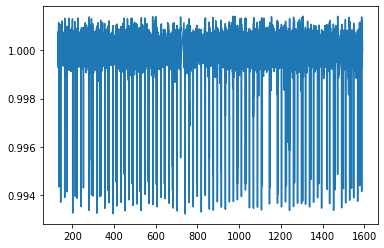

In [9]:
#Perform sigma clipping above the mean to clean the signal 
num_sigma = 2
num_sigma_above_mean = np.mean(sorted_flux) + num_sigma * (np.std(sorted_flux))

flux_value_mask = np.logical_and([x < num_sigma_above_mean for x in sorted_flux],  [x > -1000 for x in sorted_flux])
flux, flux_err, time = sorted_flux[flux_value_mask], sorted_flux_err[flux_value_mask], sorted_time[flux_value_mask]

#Remove single erroneous data point 
plt.plot(time, flux)

WRITE ABOUT LOMBSCARGLE SIGNAL PROCESSING 

In [20]:
#time_arr
dt = time_arr[1] - time_arr[0]
T = time_arr[-1] - time_arr[0]

import scipy.signal
from scipy.signal import lombscargle
freqs = np.linspace((1/T),(1/dt), 2000)
lomb = scipy.signal.lombscargle(time_arr, flux_arr, freqs, precenter=True)

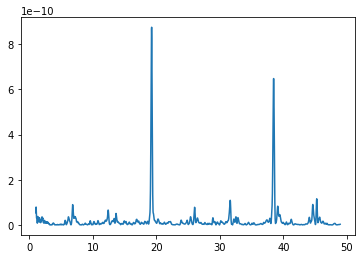

In [71]:
freqs = np.linspace((1/T),(1/dt), 2000)
lomb = scipy.signal.lombscargle(time_arr, flux_arr, freqs, precenter=True)

periods_found_from_lomb = [19.221, 38.433512752318606]
plt.plot(period, lomb2)


    period : 19.222997314785374,
    transit guess : 145.81301296925517,
    depth_guess : 0.002117254522572354
    


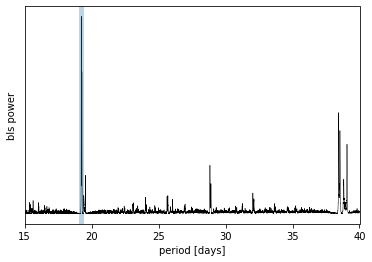

In [22]:
#Find the period, transit and peak guesses using a box least squares estimator for greater accuracy
pg = xo.estimators.bls_estimator(time, flux, flux_err, min_period=15, max_period=40)

peak = pg["peak_info"]
period_guess = peak["period"]
t0_guess = peak["transit_time"]
depth_guess = peak["depth"]

print(f"""
    period : {period_guess},
    transit guess : {t0_guess},
    depth_guess : {depth_guess}
    """
)

plt.plot(pg["bls"].period, pg["bls"].power, "k", linewidth=0.5)
plt.axvline(period_guess, alpha=0.3, linewidth=5)
plt.xlabel("period [days]")
plt.ylabel("bls power")
plt.yticks([])
_ = plt.xlim(pg["bls"].period.min(), pg["bls"].period.max())

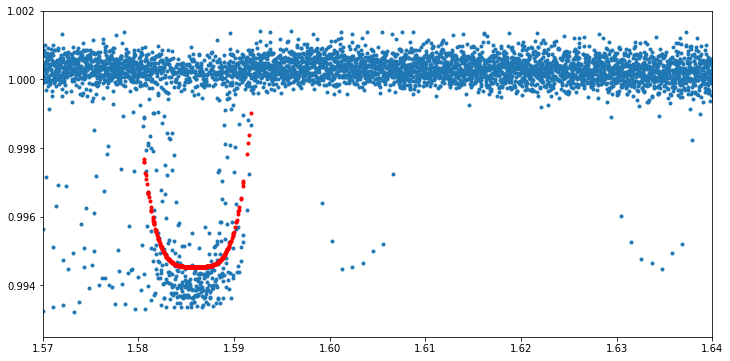

In [84]:
#Fold the lightcurve to get the transit using the period of the main found planet 
time_final, p_final, pflux_final, pflux_error_final = fold_lightcurve(
                                            time.tolist(), 
                                            flux.tolist(), 
                                            flux_err.tolist(), 
                                            period_guess
    )
#Define masks to fit the transit curve to, and a second for nice visualisation 
area_mask = (p_final > 1.5805) & (p_final < 1.593) & (pflux_final < 0.9995)
plot_mask = (p_final < 1.7) & (p_final > 1.5) 

#Fit the curve
popt, cov = curve_fit(model_curve, p_final[area_mask], pflux_final[area_mask], p0 = [0.994, 1.58, 1.593])

#Draw the figure 
plt.figure(figsize = (12, 6))
plt.plot(p_final[plot_mask], pflux_final[plot_mask], ls="None", marker="o", ms=3)#ls = 'none')
plt.plot(p_final[area_mask], model_curve(p_final[area_mask], *popt), 'r',ls="None", marker="o", ms=3)

plt.xlim(1.57, 1.64)
plt.ylim(0.9925, 1.002)
plt.show()

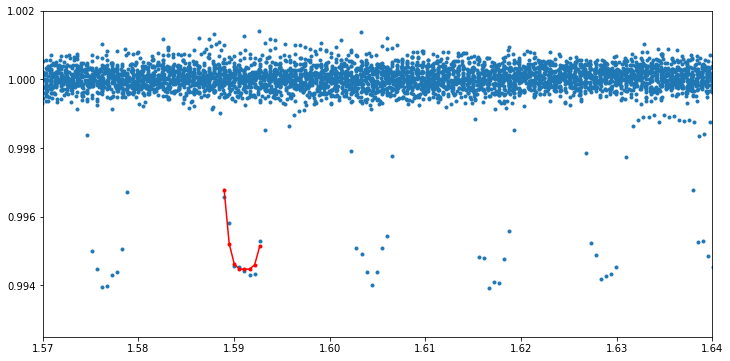

In [82]:
time_final, p_final, pflux_final, pflux_error_final = fold_lightcurve(
                                            time.tolist(), 
                                            flux.tolist(), 
                                            flux_err.tolist(), 
                                            periods_found_from_lomb[1]
    )

#area_mask = (p_final > 1.5985) & (p_final < 1.595) & (pflux_final < 0.9985)


area_mask = (p_final > 1.585) & (p_final < 1.593) & (pflux_final < 0.999)
plot_mask = (p_final < 1.7) & (p_final > 1.5) 

#Fit the curve
popt, cov = curve_fit(model_curve, p_final[area_mask], pflux_final[area_mask], p0 = [0.994,  1.587, 1.595])
#tester = model_curve(p_final[area_mask], 0.994, 1.589, 1.598)

plt.figure(figsize = (12, 6))

plt.plot(p_final[plot_mask], pflux_final[plot_mask], ls="None", marker="o", ms=3)#ls = 'none')
#plt.plot(p_final[area_mask], tester, ls="None", marker="o", ms=3)#ls = 'none')
plt.plot(p_final[area_mask], model_curve(p_final[area_mask], *popt), 'r-', marker="o", ms=3)

plt.xlim(1.57, 1.64)
plt.ylim(0.9925, 1.002)
plt.show()

MCMC STUFF 

In [88]:
#Take only the data samples within 0.25 days of a transit 
transit_mask = (
    np.abs(
        (time - t0_guess + 0.5 * period_guess) % period_guess - 0.5 * period_guess
    )
    < 0.25
)
#Data cleaning, ensure that all are float64 arrays before modelling
x = np.ascontiguousarray(time[transit_mask])
y = np.ascontiguousarray(flux[transit_mask])
yerr = np.ascontiguousarray(flux_err[transit_mask])

x_fold = (
    x - t0_guess + 0.5 * period_guess
) % period_guess - 0.5 * period_guess

#Custom mask - used to remove the 'top' line' of the transit, this isn't really needed but allows final visualization plot to look nicer 
x_fold_cord_mask = (x_fold > -0.09) & (x_fold < 0.09)
final_mask = ~np.logical_and(x_fold_cord_mask, (y > 0.999))


### 3. Discussion

$\bullet$ present comparison of your results with data, including statistical analyis and clear figures. 

$\bullet$ limit yourself in the presentation of results, focus on fewer results that are described well, rather than presenting many figures without clear context

$\bullet$ Include a short (~ 200 word) description of a follow-up observations that would address an open question in your report.


<div class="alert alert-block alert-danger">
<b>Word limit: 2000 words</b>

### 4. Summary

$\bullet$ summarize your results. This can be done in text or bullet points.

<div class="alert alert-block alert-danger">
<b>Word limit: 300 words</b>

### References:

Give all references here. Use Astronomy style references, e.g.
- Miller & Jones, 2018, ApJ, 00, 000
- Smith et al. 2019, MNRAS, 00, 000
- Willow 1972, AJ, 00, 000

And cite these in the text as "Miller & Jones (2018) showed that all exoplanets are made of cheese, however, Smith et al. (2019) showed Trappist1b is made of chocolate, as previously suggested in the literature (Willow 1972)." 


### Acknowledgments

Acknowlegde the use of any software or datasets here.